# `OceInterp` Lagrangian particle demonstration. This version uses the ECCO MITgcm velocity field data available on SciServer.

### Wenrui Jiang, Tom Haine Feb '23

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import oceanspy as ospy

### The ECCO MITgcm run is a low-resolution global state estimate, available on SciServer. The simulation is opened using the OceanSpy package.

Choose between the monthly-mean data ('ECCO') or the daily-mean data ('daily_ecco').

### See: https://dev-poseidon-ocean.pantheonsite.io/products/datasets/.

In [2]:
ecco = ospy.open_oceandataset.from_catalog('ECCO')
# ecco = ospy.open_oceandataset.from_catalog('daily_ecco')

Opening ECCO.
ECCO v4r4 3D dataset, ocean simulations on LLC90 grid (monthly mean output)


#### The following is not necessary, but it's faster if you have `maskU` and `maskV` at hand.

In [3]:
# ecco._ds['maskU'] = ecco._ds['maskC']
# ecco._ds['maskU'].values = np.load('maskU.npy')
# ecco._ds['maskV'] = ecco._ds['maskC']
# ecco._ds['maskV'].values = np.load('maskV.npy')

### Initialize OceInterp package. Then set the debug level.

In [4]:
import OceInterp as oi
oi.rcParam['debug_level'] = 'very_high'   # Options are: 'high','very_high','not that high'

### Specify the parameters for the particles (number, positions, start time).

In [5]:
# Change the number of particles here
N = int(1e2)

# Change the vertical depth of the particles here
levels = np.array([-5])
sqrtN = int(np.sqrt(N))

# Change the longitude and latitude positions of the particles here
xx = np.linspace(-19,-9,sqrtN)
yy = np.linspace(63,57,sqrtN)

# Compute intermediate grid variables
xxx,yyy = np.meshgrid(xx,yy)
x = xxx.ravel()
y = yyy.ravel()
x,z = np.meshgrid(x,levels)
y,z = np.meshgrid(y,levels)
x = x.ravel()
y = y.ravel()
z = z.ravel()

# Change the times here
start_time = '1998-12-15'
t = (np.array([np.datetime64(start_time) for i in x])
     -np.datetime64('1970-01-01'))/np.timedelta64(1, 's')

#### Plot the particle positions

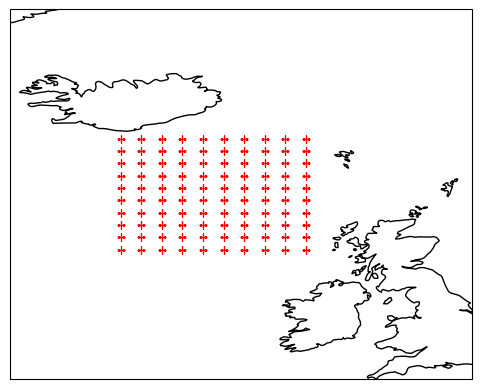

In [6]:
ax = plt.axes(projection = ccrs.PlateCarree())
ax.plot(xxx,yyy,'r+')
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.show()

### Let's explore the interpolation function in `OceInterp`:

In [7]:
help(oi.OceInterp)

Help on function OceInterp in module OceInterp.OceInterp:

OceInterp(od, varList, x, y, z, t, kernelList=None, lagrangian=False, lagrange_kwarg={}, update_stops='default', return_in_between=True, return_pt_time=True, **kernel_kwarg)
    The center piece function of the package, from here 
    you can access almost all the functionality of the 
    package.
    -------
    od: OceInterp.OceData object or xarray.Dataset (hopefully also netcdf)
        the dataset to work on
    varList: str or lst
        (list of) variable/pair of variables
    kernelList: OceInterp.KnW/list of OceInterp.KnW object
        which kernel to use for each interpolation
    x,y,z: numpy.ndarray
        location of the particles, x,y are in degrees, and 
        z are in meters, the deeper, the more negative. 
    t: numpy.ndarray
        In Eulerian scheme, the time of interpolation.
        In Lagrangian scheme, the time needed for output. 
    lagrangian: bool
        whether the interpolation is done in E

### Interpolate these ECCO fields onto the particle positions.

In [8]:
[s,(u,v),eta,mask] = oi.OceInterp(ecco._ds,['SALT',('UVELMASS','VVELMASS'),'ETAN','maskC'],x,y,z,t)

Creating new weight function, the first time is going to be slow
Creating new weight function, the first time is going to be slow


### Plot the interpolated salinity field.

Text(0.5, 1.0, 'Salinity (psu)')

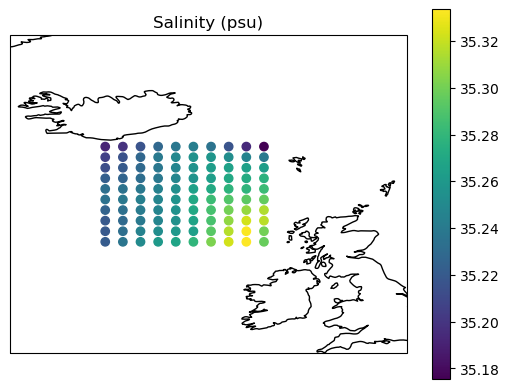

In [9]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = s)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Salinity (psu)')

### Plot the interpolated $u$ field.

Text(0.5, 1.0, 'Zonal Velocity (m/s)')

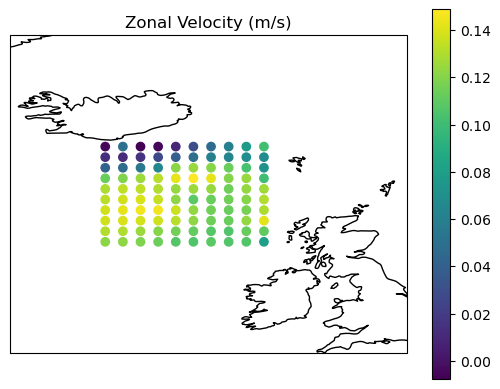

In [10]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = u)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Zonal Velocity (m/s)')

### Plot the interpolated $\eta$ field.

Text(0.5, 1.0, 'Sea Surface Height (m)')

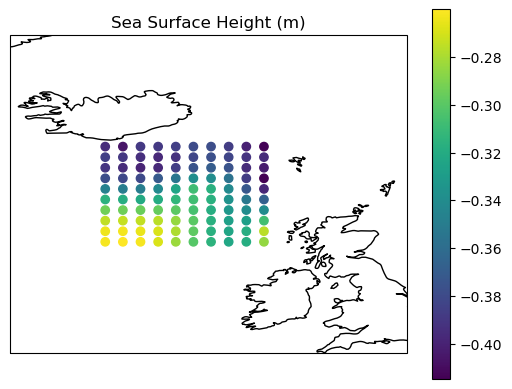

In [11]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = eta)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Sea Surface Height (m)')

### Now compute Lagrangian trajectories for these particles.

#### Define the `start_time` and `end_time`. Here the particles are integrated backwards in time.

In [12]:
start_time = '1998-12-15'
end_time = '1998-09'

t_bnds = np.array([
    np.datetime64(start_time)-np.datetime64('1970-01-01'),
    np.datetime64(  end_time)-np.datetime64('1970-01-01')
])/np.timedelta64(1, 's')

### Perform the particle trajectory simulation.

#### Record the salinity along the particle trajectories as well as their (lat,lon) positions.

In [13]:
stops,[s,raw,lat,lon] = oi.OceInterp(ecco._ds,
                                 ['SALT','__particle.raw','__particle.lat','__particle.lon'],
                                 x,y,z,t_bnds,
                                 lagrangian = True,
                                 return_pt_time = True,
                                 lagrange_kwarg={'save_raw':True}
                                    )


1998-12-01T06:00:00
100 left 98 left 91 left 63 left 17 left 
1998-10-31T18:00:00
100 left 100 left 100 left 100 left 95 left 84 left 67 left 33 left 5 left 
1998-10-01T06:00:00
100 left 100 left 96 left 85 left 77 left 51 left 16 left 
1998-09-01T00:00:00
100 left 87 left 62 left 31 left 8 left 1 left 

#### There are 4 output times. See also the diagnostic output from running the integration.

In [14]:
stops

(912492000.0, 909856800.0, 907221600.0, 904608000.0)

#### The `raw` output is a vector of `OceInterp` objects with position information

In [15]:
raw

### Plot the interpolated salinity field on the final particle positions.

Text(0.5, 1.0, 'salinity map')

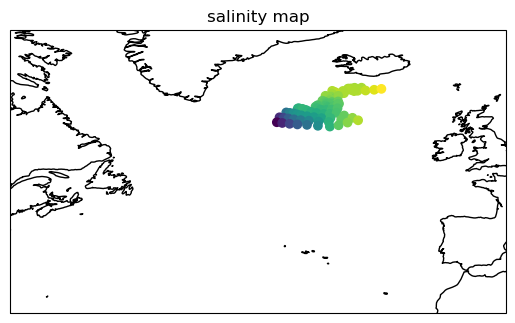

In [16]:
ax = plt.axes(projection = ccrs.PlateCarree())
ax.scatter(lon[-1],lat[-1],c = s[-1])
ax.coastlines()
ax.set_xlim([-70,0])
ax.set_ylim([30,70])
plt.title('salinity map')

### There are some other `OceInterp` classes:

#### 1. Kernel object

In [17]:
KnW = oi.kernelNweight.KnW

#### Define derivative kernels for $\partial / \partial z$, $\partial^2 / \partial x^2$, and $\partial / \partial t$.

In [18]:
default = KnW()
dz_kernel = KnW(vkernel = 'dz')
dx2_kernel = KnW(hkernel = 'dx',h_order = 2,inheritance = [[0,1,2,3,4,5,6,7,8]],tkernel = 'linear')
dt_kernel = KnW(tkernel = 'dt')

Creating new weight function, the first time is going to be slow


#### Apply the kernels to the ECCO fields:

In [19]:
[dsdz,(d2udx2,dvdt)] = oi.OceInterp(ecco._ds,{'SALT':dz_kernel,('UVELMASS','VVELMASS'):(dx2_kernel,dt_kernel)},x,y,z,t)

result will be in the order of ['SALT', ('UVELMASS', 'VVELMASS')]
creating maskU, this is going to be slow!
creating maskV, this is going to be slow!


### Plot one of the differentiated fields on the initial particle positions.

Text(0.5, 1.0, 'Second Derivative of the Zonal Velocity (m/s per grid scale squared)')

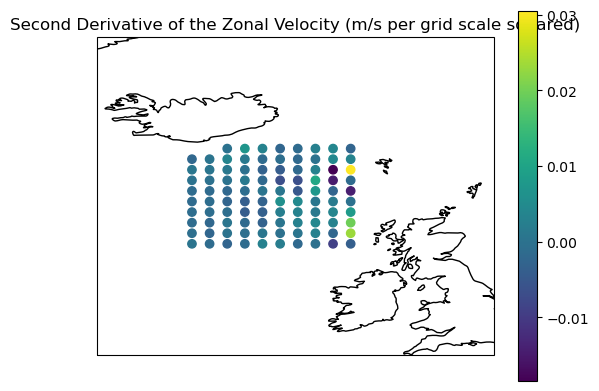

In [20]:
ax = plt.axes(projection = ccrs.PlateCarree())
c = ax.scatter(x,y,c = d2udx2)
ax.coastlines()
ax.set_xlim([-25,0])
ax.set_ylim([50,70])
plt.colorbar(c)
plt.title('Second Derivative of the Zonal Velocity (m/s per grid scale squared)')